In [2]:
%load_ext autoreload
%autoreload 2


In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
from src.data.orto_dataset import OrtoDataset
from torch.utils.tensorboard import SummaryWriter

In [3]:
image_size = 224
dataset = OrtoDataset("..\\..\\datasets\\orto_triplet_dataset", image_size, train=True)
train_dataloader = DataLoader(dataset, batch_size=150, shuffle=True, num_workers=10, prefetch_factor=4)


test_dataset = OrtoDataset("..\\..\\datasets\\orto_triplet_dataset", image_size, train=False)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=100, num_workers=10, prefetch_factor=4)


In [4]:
def set_training_model_layers(model, training: bool, up_to_index: int):
    i = 0
    for child in model.children():
        if i > up_to_index:
            break
        for param in child.parameters():
            param.requires_grad = training
        i+=1

In [33]:
def load_training_state(path):
    model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
    model.fc = torch.nn.Linear(512, 100, bias=True)
    set_training_model_layers(model, False, 8)
    model = model.cuda()
    optim = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optim.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optim

In [34]:
# model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)

# model.fc = torch.nn.Linear(512, 100, bias=True)
# set_training_model_layers(model, False, 8)
# model = model.cuda()
# optim = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
model, optim = load_training_state("300_checkpoint.pt")
criterion = torch.nn.TripletMarginLoss()

Using cache found in C:\Users\Szymon/.cache\torch\hub\pytorch_vision_master


In [6]:
# set_training_model_layers(model, True, 8)

In [20]:

iters = 302
writer = SummaryWriter()
t = trange(iters)
for epoch in t:
    loss_sum = 0.0
    for i_batch, sample_batched in enumerate(train_dataloader):
        optim.zero_grad()
        
        anchors = sample_batched['a'].cuda()
        positives = sample_batched['p'].cuda()
        negatives = sample_batched['n'].cuda()
        a = model(anchors)
        p = model(positives)
        n = model(negatives)
        loss = criterion(a, p, n)
        loss.backward()
        loss_sum += float(loss)
        optim.step()
        t.set_description(f"Batch: {i_batch}")
    del a
    del p
    del n
    del loss
    
    train_loss = loss_sum / len(train_dataloader)
    writer.add_scalar('Loss/train', train_loss, epoch)
    t.set_description(f"Epoch: {epoch}, Train loss: {train_loss}")

Epoch: 301, Train loss: 0.0632115363042629: 100%|██████████| 302/302 [20:26:08<00:00, 243.61s/it]


In [21]:
paths = []
embeddings = []

with torch.no_grad():
    for i_batch, sample_batched in tqdm(enumerate(test_dataloader)):
        anchors = sample_batched['a'].cuda()
        anchor_paths = sample_batched['path']
        paths.extend(anchor_paths)
        a = model(anchors).cpu().numpy()
        embeddings.append(a)

    embeddings = np.concatenate(embeddings)



591it [03:41,  2.67it/s]


In [22]:
import pickle as pkl
with open(f"embeddings_{iters}.pkl.gz", "wb") as f:
    pkl.dump(embeddings, f)

In [23]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# tsne_embeddings = TSNE(n_components=2, verbose=100, n_jobs=15).fit_transform(embeddings)
tsne_embeddings = PCA(n_components=2).fit_transform(embeddings)


In [24]:
import os
import pickle as pkl
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

with open(f"embeddings_{iters}.pkl.gz", "rb") as f:
    embeddings = pkl.load(f)
# tsne_embeddings = PCA(n_components=2).fit_transform(embeddings)
tsne_embeddings = TSNE(n_components=2, verbose=10, n_jobs=15).fit_transform(embeddings)
with open(f"tsne-embeddings_{iters}.pkl.gz", "wb") as f:
    pkl.dump(tsne_embeddings, f)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 59080 samples in 1.147s...
[t-SNE] Computed neighbors for 59080 samples in 56.618s...
[t-SNE] Computed conditional probabilities for sample 1000 / 59080
[t-SNE] Computed conditional probabilities for sample 2000 / 59080
[t-SNE] Computed conditional probabilities for sample 3000 / 59080
[t-SNE] Computed conditional probabilities for sample 4000 / 59080
[t-SNE] Computed conditional probabilities for sample 5000 / 59080
[t-SNE] Computed conditional probabilities for sample 6000 / 59080
[t-SNE] Computed conditional probabilities for sample 7000 / 59080
[t-SNE] Computed conditional probabilities for sample 8000 / 59080
[t-SNE] Computed conditional probabilities for sample 9000 / 59080
[t-SNE] Computed conditional probabilities for sample 10000 / 59080
[t-SNE] Computed conditional probabilities for sample 11000 / 59080
[t-SNE] Computed conditional probabilities for sample 12000 / 59080
[t-SNE] Computed conditional probabilities for sa

In [25]:
torch.save({
            'epoch': 300,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            }, "300_checkpoint.pt")

In [26]:
paths = [os.path.join("..\\..\\datasets\\orto_triplet_dataset\\anchor",f) for f in os.listdir("..\\..\\datasets\\orto_triplet_dataset\\anchor")]
size = 5000
random_selections = np.random.choice(np.arange(len(paths)), size=size, replace=False)

selected_paths = np.array(paths)[random_selections].tolist()
selected_embeddings = tsne_embeddings[random_selections, :]

from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


def visualize_embeddings(embeddings: np.array, image_paths, name: str):

    def get_image(path):
        img = Image.open(path)
        a = np.asarray(img)
        return OffsetImage(a, zoom=0.08)


    fig, ax = plt.subplots(figsize=(30,30))
    ax.scatter(embeddings[:, 0], embeddings[:, 1]) 
    for image_path, (x, y) in tqdm(zip(image_paths, embeddings)):
        ab = AnnotationBbox(get_image(image_path), (x, y), frameon=False)
        ax.add_artist(ab)
    fig.savefig(name, dpi=300)
    print("saved")
    plt.close()

    return 0

visualize_embeddings(selected_embeddings, selected_paths, f"tsne_{iters}.png")


5000it [00:35, 141.04it/s]


saved


0

In [27]:
from umap import UMAP
with open(f"embeddings_{iters}.pkl.gz", "rb") as f:
    embeddings = pkl.load(f)
umap = UMAP().fit_transform(embeddings)
paths = [os.path.join("..\\..\\datasets\\orto_triplet_dataset\\anchor",f) for f in os.listdir("..\\..\\datasets\\orto_triplet_dataset\\anchor")]
size = 5000
# random_selections = np.random.choice(np.arange(len(paths)), size=size, replace=False)

# selected_paths = np.array(paths)[random_selections].tolist()
selected_embeddings = umap[random_selections, :]
visualize_embeddings(selected_embeddings, selected_paths, f"umap_{iters}.png")

5000it [00:16, 309.14it/s]


saved


0

In [28]:
torch.save(model.state_dict(), f"model_{iters}.pt")


In [29]:
from sklearn.metrics import pairwise_distances

distances = pairwise_distances(embeddings)

In [30]:

for i, ble in enumerate(paths):
    if os.path.basename(ble) == "orto2020split.40534.tif":
        found_i, found_path = i, ble
        print(i, ble)

32464 ..\..\datasets\orto_triplet_dataset\anchor\orto2020split.40534.tif


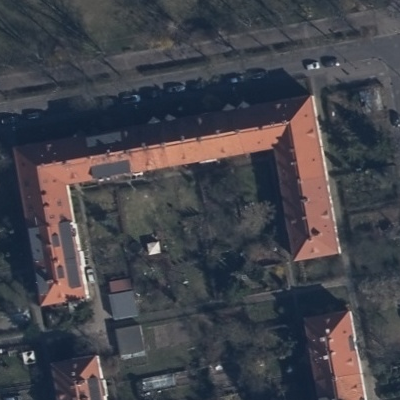

In [31]:
Image.open(paths[found_i])

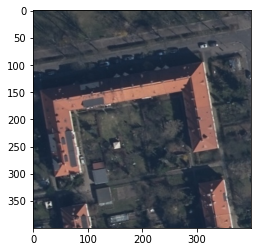

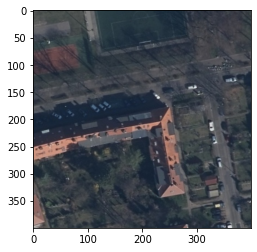

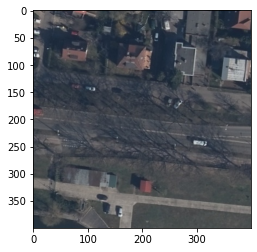

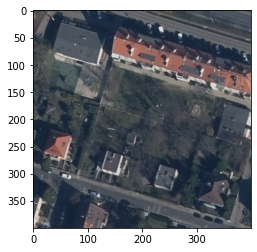

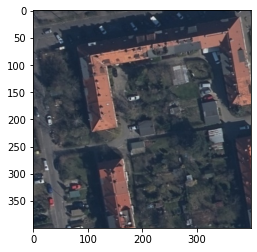

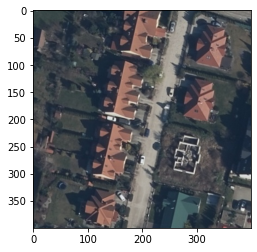

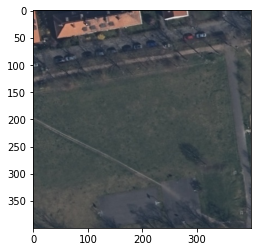

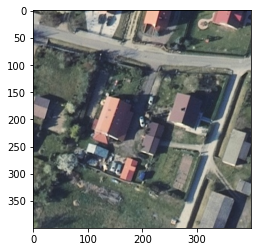

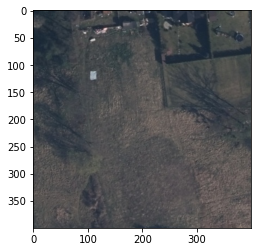

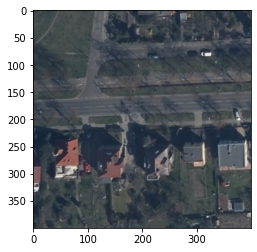

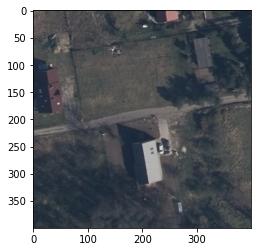

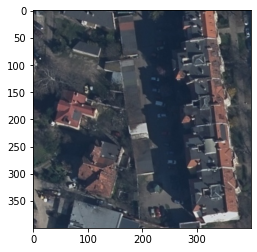

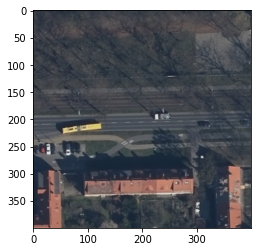

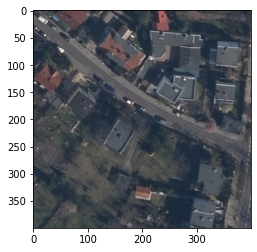

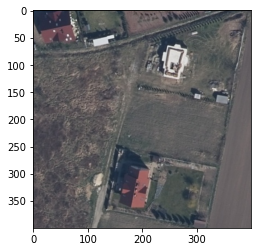

In [32]:
for i in distances[found_i, :].argsort()[:15]:
    plt.imshow(Image.open(paths[i]))
    plt.show()